# CS579: Assignment 3

In this assignment, you will fit a text classifier to categorize movie reviews by sentiment.

In [1]:
from collections import Counter
import glob
import hashlib
import io
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tarfile
from urllib import urlretrieve
%matplotlib inline

In [2]:
def get_data():
    """ Download and unzip data."""
    urlretrieve('https://www.dropbox.com/s/xk4glpk61q3qrg2/imdb.tgz?dl=1', 'imdb.tgz')
    tar = tarfile.open("imdb.tgz")
    tar.extractall()
    tar.close()
    
get_data()

In [40]:
# Here is the path to the data directory.
path = 'data'
print('subdirectories are:' + str(os.listdir(path)))

subdirectories are:['test', 'train']


In [41]:
print(str(os.listdir(path + os.sep + 'train' + os.sep + 'pos')))
type (os.listdir(path + os.sep + 'train' + os.sep + 'pos'))

['10057_9.txt', '10137_7.txt', '10155_9.txt', '10230_9.txt', '10231_10.txt', '10281_7.txt', '10596_8.txt', '10605_7.txt', '10614_7.txt', '1062_10.txt', '10670_10.txt', '10687_10.txt', '10694_7.txt', '10697_8.txt', '10739_10.txt', '10777_9.txt', '10847_10.txt', '10932_7.txt', '11027_10.txt', '11059_9.txt', '1111_10.txt', '11179_9.txt', '11196_7.txt', '11224_8.txt', '11287_8.txt', '11384_7.txt', '11401_9.txt', '11442_10.txt', '11497_10.txt', '11534_7.txt', '11637_8.txt', '11647_8.txt', '11676_8.txt', '11682_7.txt', '11814_7.txt', '11900_8.txt', '11990_10.txt', '12014_10.txt', '120_8.txt', '12228_8.txt', '12260_10.txt', '12264_9.txt', '12318_9.txt', '1233_7.txt', '12403_8.txt', '1245_7.txt', '1272_7.txt', '132_9.txt', '1334_8.txt', '1342_10.txt', '1343_9.txt', '1568_9.txt', '1577_9.txt', '1590_10.txt', '1710_7.txt', '1755_10.txt', '1770_10.txt', '1811_10.txt', '1829_8.txt', '185_9.txt', '1971_9.txt', '2078_9.txt', '2166_7.txt', '218_9.txt', '2215_8.txt', '2272_7.txt', '2310_9.txt', '2349_

list

In [42]:
def get_files(path):
    """ Return a list of file names in this directory that end in .txt 
    The list should be sorted alphabetically by file name.
    Params:
        path....a directory containing .txt review files.
    Returns:
        a list of .txt file names, sorted alphabetically.
    """
    ###TODO
    ###
    return sorted([path +os.sep +x for x in os.listdir(path) if x.endswith(".txt")])

In [43]:
pos_train_files = get_files(path + os.sep + 'train' + os.sep + 'pos')
neg_train_files = get_files(path + os.sep + 'train' + os.sep + 'neg')
all_train_files = pos_train_files + neg_train_files

print('found %d positive and %d negative training files' %
      (len(pos_train_files), len(neg_train_files)))
print('first positive file: %s' % pos_train_files[0])
print('first negative file: %s' % neg_train_files[0])

found 200 positive and 200 negative training files
first positive file: data\train\pos\10057_9.txt
first negative file: data\train\neg\10108_1.txt


In [44]:
def get_true_labels(file_names):
    """Return a *numpy array* of ints for the true sentiment labels of each file.
    1 means positive, 0 means negative. Use the name of the file to determine
    the true label.
    Params:
        file_names....a list of .txt file paths, e.g., data/train/pos/10057_9.txt
    Returns:
        a numpy array of 1 or 0 values corresponding to each element
        of file_names, where 1 indicates a positive review, and 0
        indicates a negative review.
    """
    ###TODO
    ###
    final=[]
    for x in file_names:
        if "pos"  in x:
            final.append(1)
        if "neg"  in x:
            final.append(0)
    return np.asarray(final)

labels = get_true_labels(all_train_files)
print('first 3 and last 3 labels are: %s' % str(labels[[1,2,3,-3,-2,-1]]))

first 3 and last 3 labels are: [1 1 1 0 0 0]


In [45]:
# Here's what a positive review looks like.
def file2string(filename):
    return io.open(filename, encoding='utf8').readlines()[0]
    
file2string(pos_train_files[10])

u"This is a great film!! The first time I saw it I thought it was absorbing from start to finish and I still do now. I may not have seen the play, but even if I had it wouldn't stop me thinking that the film is just as good."

In [46]:
def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    ###
    text = text.lower()
    tokens = re.sub('\W+', ' ', text).split()
    return tokens

tokenize("Hi! How's it going??? an_underscore is not *really* punctuation.")

['hi',
 'how',
 's',
 'it',
 'going',
 'an_underscore',
 'is',
 'not',
 'really',
 'punctuation']

In [47]:
def do_vectorize(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    ###TODO
    ###
    t= CountVectorizer(input='filename', tokenizer=tokenizer_fn, min_df=min_df, max_df=max_df, binary=binary, ngram_range=ngram_range, dtype=int)
    x= t.fit_transform(filenames)
    return (x,t)
matrix, vec = do_vectorize(all_train_files)
print ('matrix represents %d documents with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[0].nonzero()[1]))))

matrix represents 400 documents with 10710 features
first doc has terms:
[128, 170, 202, 253, 260, 312, 355, 439, 504, 514, 560, 673, 683, 702, 750, 860, 869, 961, 985, 1013, 1222, 1254, 1312, 1341, 1403, 1444, 1451, 1469, 1504, 1658, 1665, 1743, 2465, 2537, 2996, 3109, 3206, 3229, 3356, 3368, 3515, 3634, 3706, 3716, 3759, 3810, 3926, 4015, 4059, 4061, 4087, 4139, 4205, 4207, 4222, 4309, 4366, 4384, 4412, 4435, 4472, 4510, 4524, 4631, 4690, 4757, 4798, 5062, 5074, 5225, 5274, 5287, 5289, 5312, 5360, 5418, 5609, 5610, 5646, 5693, 5761, 5888, 5932, 5948, 6116, 6243, 6258, 6294, 6424, 6440, 6579, 6620, 6676, 6696, 6860, 6942, 7094, 7626, 8052, 8248, 8336, 8341, 8474, 8767, 8988, 9204, 9412, 9436, 9440, 9505, 9508, 9523, 9550, 9558, 9634, 9684, 9690, 9835, 9855, 9857, 10047, 10337, 10353, 10431, 10441, 10446, 10448, 10519]


In [48]:
# Do not modify. This is to randomize the order of the documents, but
# in a way that is consistent across platforms.
# See: http://stackoverflow.com/a/18992474/1756896
# You should run this block once to get the shuffled data.
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(filenames)[indices]

X, y, filenames = repeatable_shuffle(matrix, labels, all_train_files)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames[0], y[0], sorted(X[0].nonzero()[1])))

first shuffled document data\train\pos\5140_10.txt has label 1 and terms: [98, 170, 355, 384, 514, 720, 750, 780, 1225, 2234, 3356, 3682, 3916, 4015, 4397, 4690, 4798, 5074, 5080, 5764, 5948, 6579, 6782, 6950, 7899, 8186, 8587, 9045, 9508, 9550, 9609, 9827, 10003, 10421, 10640]


In [49]:
# Do not modify. This creates a LogsticRegression object, which
# you will use in the do_cross_validation method below.
def get_clf():
    return LogisticRegression(random_state=42)

In [50]:
def do_cross_validation(X, y, n_folds=5, verbose=False):
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    ###TODO
    ###
    t = KFold(len(y), n_folds)
    accuracies = []
    i=0
    for train_idx, test_idx in t:
        clf = LogisticRegression()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        if verbose:
            print 'fold %d accuracy = %.4f' % (i, acc)
        i=i+1
        accuracies.append(acc)
    avg = np.mean(accuracies)
    return avg
    
print('average cross validation accuracy=%.4f' %
      do_cross_validation(X, y, verbose=True))

fold 0 accuracy = 0.7125
fold 1 accuracy = 0.7750
fold 2 accuracy = 0.7750
fold 3 accuracy = 0.7250
fold 4 accuracy = 0.7125
average cross validation accuracy=0.7400


In [51]:
def do_expt(filenames, y, tokenizer_fn=tokenize,
            min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=5):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        filenames.......list of review file names
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    ###TODO
    ###
    X, t = do_vectorize(filenames.tolist(), binary=binary, 
                               tokenizer_fn=tokenizer_fn, 
                               min_df=min_df, max_df=max_df)
    
    return do_cross_validation(X, y, n_folds)

In [52]:
print('accuracy using default settings: %.4g' % do_expt(filenames, y))

accuracy using default settings: 0.74


## Compare accuracy of various settings

Next, we'll try out a few different settings to see how they affect cross-validation accuracy.

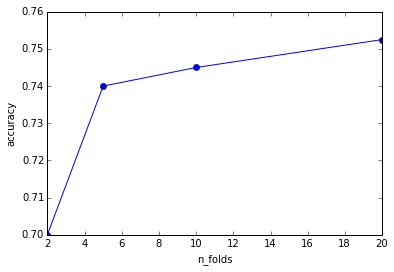

[0.69999999999999996, 0.73999999999999999, 0.745, 0.75250000000000006]

In [53]:
def compare_n_folds(filenames, y):
    """
    Vary the setting of n_folds parameter in the do_expt 
    function to be in [2,5,10,20]. For each setting, call do_expt and 
    store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per fold.
    """
    ###TODO
    ###
    acc = []
    n_folds = [2,5,10,20]
    for n in n_folds:
        acc.append(do_expt(filenames, y, n_folds=n))
    plt.figure()
    plt.xlabel('n_folds')
    plt.ylabel('accuracy')
    plt.plot(n_folds, acc, 'bo-')
    plt.show()
    return acc
    
compare_n_folds(filenames, y)

Why do you think accuracy increases as the number of folds increases?

**Enter your answer here in this cell:**


As we are increasing the number of folds, we divide our training data in that many numbers. We will make one portion of this divided training set as test data. Now, we try to fit our classifier with all remaining training part and test on the folded part. This process will be performeed for keeping each division as a testing set in each itteration. 
So as we increase the number of fold, we are increasing itteration and we can set our classifier more closly to our training data set and so achive heigher accuracy.







In [76]:
def compare_binary(filenames, y):
    """
    How does the binary parameter affect results? 
    Call do_expt twice, once with binary=True, and once with binary=False.
    Return the average accuracies for each. Use the default parameters for the
    remaining arguments in do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies. The first entry
        is for binary=True, the second is for binary=False.
    """
    ###TODO
    ###
    acc = []
    acc.append(do_expt(filenames, y, binary = True))
    acc.append(do_expt(filenames, y, binary = False))
    return acc
          
compare_binary(filenames, y)

[0.73999999999999999, 0.69999999999999996]

Why do you think using binary feature vectors does better than using term frequency?

**Enter your answer here in this cell:**

As Binary vector only have True or False , while frequency vector have multiple values. So Classifier can have ease in predictig only two values TRUE or FALSE then different frequency value.
More data is needed in predicing accurate frequncy vector, as we have less data, binary is good here.







** Next, we will compare three different tokenization functions. **

In [55]:
def tokenize_with_punct(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is kept as separate tokens.
    Note that underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    ###
    tokens = re.findall("\w+|[^\w\s\x85]", text.lower())
    return tokens

tokenize_with_punct("Hi! How's it going??? an_underscore is not *really* punctuation.")

['hi',
 '!',
 'how',
 "'",
 's',
 'it',
 'going',
 '?',
 '?',
 '?',
 'an_underscore',
 'is',
 'not',
 '*',
 'really',
 '*',
 'punctuation',
 '.']

A common problem in sentiment analysis is **negation.** E.g., "This movie is **not** good" and "This movie is good" will have very similar feature vectors. However, the term **good** in the first sentence is clearly being used differently than in the second sentence. The tokenizer below attempts to distinguish between these cases.

In [56]:
def tokenize_with_not(text):
    """Does the same thing as tokenize_with_punct, with the following difference:
    whenever the term 'not' appears, change the two subsequent tokens to have the prefix
    'not_' prior to the token. See the example below. You may call 
    tokenize_with_punct as a subroutine.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    ###
    token = tokenize_with_punct(text)
    t = len(token)
    for n in range(t):
        if token[n] == 'not':
            if n+1 < t :
                token[n+1] = "not_" + token[n+1]
            if n+2 < t :
                token[n+2] = "not_" + token[n+2]
    return token

tokenize_with_not("This movie is not good. In fact, it is not even really a movie.")

['this',
 'movie',
 'is',
 'not',
 'not_good',
 'not_.',
 'in',
 'fact',
 ',',
 'it',
 'is',
 'not',
 'not_even',
 'not_really',
 'a',
 'movie',
 '.']

In [57]:
# To keep things simple, we'll pretend that non-ascii 
# characters are punctuation.
nonascii_string = u'not the fiancée of not Henri'
print nonascii_string
print('tokenize: %s' % 
      ', '.join(tokenize(nonascii_string)))
print('tokenize_with_punct: %s' %
      ', '.join(tokenize_with_punct(nonascii_string)))
print('tokenize_with_not: %s' %
      ', '.join(tokenize_with_not(nonascii_string)))

not the fiancée of not Henri
tokenize: not, the, fianc, e, of, not, henri
tokenize_with_punct: not, the, fianc, é, e, of, not, henri
tokenize_with_not: not, not_the, not_fianc, é, e, of, not, not_henri


In [58]:
nonascii_string = u'énot the\x85fiancéée-\n\rof not Henrié '
print 'tokenize:', tokenize(nonascii_string)
print 'with punct:', tokenize_with_punct(nonascii_string)
print 'with not:', tokenize_with_not(nonascii_string)

tokenize: [u'not', u'the', u'fianc', u'e', u'of', u'not', u'henri']
with punct: [u'\xe9', u'not', u'the', u'fianc', u'\xe9', u'\xe9', u'e', u'-', u'of', u'not', u'henri', u'\xe9']
with not: [u'\xe9', u'not', u'not_the', u'not_fianc', u'\xe9', u'\xe9', u'e', u'-', u'of', u'not', u'not_henri', u'not_\xe9']


In [59]:
def tokenizer_expt(all_train_files, y):
    """
    How does the tokenizer affect results? 
    Call do_expt three times, using three different tokenizers:
    1- tokenize
    2- tokenize_with_punct
    3- tokenize_with_not
    Return the average cross-validation accuracy for each approach,
    in the above order. Use the default parameters for all other 
    arguments to do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies for each tokenizer.
    """
    ###TODO
    ###
    acc = []
    acc.append(do_expt(filenames, y, tokenizer_fn=tokenize))
    acc.append(do_expt(filenames, y, tokenizer_fn=tokenize_with_punct))
    acc.append(do_expt(filenames, y, tokenizer_fn=tokenize_with_not))
    return acc

tokenizer_expt(filenames, y)

[0.73999999999999999, 0.74499999999999988, 0.74749999999999994]

**We can see that tokenize_with_not results in slightly higher accuracy.
In all experiments below, be sure to use tokenize_with_not as the tokenizer.**

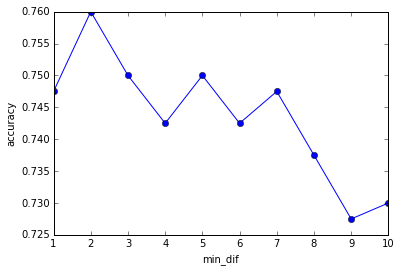

[0.74749999999999994,
 0.76000000000000001,
 0.75000000000000011,
 0.74249999999999994,
 0.74999999999999989,
 0.74249999999999994,
 0.74749999999999994,
 0.73750000000000004,
 0.72750000000000004,
 0.73000000000000009]

In [60]:
def min_df_expt(filenames, y):
    """
    Vary the setting of min_df parameter in the do_expt 
    function to be ints in the range (1,10) (inclusive). For each setting,
    call do_expt and store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function, except that the tokenizer
    should be tokenize_with_not.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per min_df value.
    """
    ###TODO
    ###
    acc = []
    for n in range(1,11):
        acc.append(do_expt(filenames, y, tokenizer_fn=tokenize_with_not, min_df=n))
    plt.figure()
    plt.xlabel('min_dif')
    plt.ylabel('accuracy')
    plt.plot(range(1,11), acc, 'bo-')
    plt.show()
    return acc

min_df_expt(filenames, y)

In [61]:
print range(1,11)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


The best accuracy occurs when **min_df=2.** Why do you think this is better than setting **min_df=1**.

**Enter your answer here in this cell:**


min_df is actually remove terms from the vocabulary that don't appear in at least this many documents. 
But actually we prepare vocabulary as terms found in documents. setting min_df = 1 means removing terms which have not appear in any of the documents which are none in this case, so it doesnt matter. While keeping min_df = 2 we remove low frequent words from vocabulary that help us to gain accuracy.







**Be sure to set min_df=2 in all experiments below.**

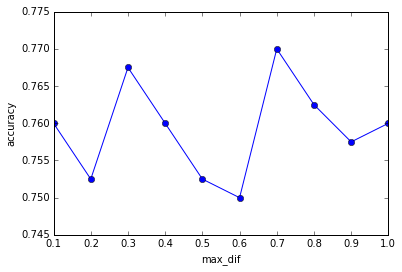

[0.76000000000000001,
 0.75250000000000006,
 0.76749999999999996,
 0.76000000000000001,
 0.75250000000000006,
 0.74999999999999989,
 0.77000000000000013,
 0.76250000000000007,
 0.75749999999999995,
 0.76000000000000001]

In [62]:
def max_df_expt(filenames, y):
    """
    Vary the setting of max_df parameter in the do_expt 
    function to be one of [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.].
    For each setting, call do_expt and store the resulting accuracy.
    Plot the accuracies for each setting. Also return the list of accuracies.
    Use the default value for all other arguments to the do_expt function,
    except that the tokenizer=tokenize_with_not and min_df=2.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per max_df value.
    """
    ###TODO
    ###
    maxDf = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
    acc = []
    for i in maxDf:
        acc.append(do_expt(filenames, y, tokenizer_fn=tokenize_with_not, max_df=i, min_df = 2))
    plt.figure()
    plt.xlabel('max_dif')
    plt.ylabel('accuracy')
    plt.plot(maxDf, acc, 'bo-')
    plt.show()
    return acc

    
max_df_expt(filenames, y)

**So, based on the above experiments, we set:**

- binary=True
- tokenizer=tokenize_with_not
- min_df=2
- max_df=.7

This results in 5-fold cross-validation accuracy of 76.7%.

## Inspecting coefficients

Next we'll look at the coefficients learned by LogisticRegression to 
determine how it is making its classification decisions.

In [63]:
# First, we'll train our final classifier using our best settings.
X, vec = do_vectorize(filenames, tokenizer_fn=tokenize_with_not,
                      binary=True, min_df=2, max_df=.7)
clf = get_clf()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0)

The LogisticRegression variable (`clf`) has an attribute `.coef_`, which are the learned model coefficients. This is a numpy array with a real value for each term in the vocabulary. Positive values indicate a correlation with the positive class, negative values indicate a correlation with the negative class.

In [64]:
print type(clf.coef_)
print clf.coef_.shape

<type 'numpy.ndarray'>
(1L, 4734L)


In [65]:
# Here are the first 10 coefficients.
print(clf.coef_[0][:10])
# The features corresponding to them can be found using the vectorizer's get_feature_names method.
print(vec.get_feature_names()[:10])

[ 0.3021783  -0.31127296 -0.01907905 -0.13228897  0.05602542  0.16796849
 -0.11328267  0.03523083 -0.13081422 -0.05752848]
[u'!', u'"', u'#', u'$', u'%', u'&', u'(', u')', u'*', u'+']


In [66]:
def get_top_coefficients(clf, vec, n=10):
    """ Get the top n coefficients for each class (positive/negative).
    Params:
        clf...a LogisticRegression object that has already been fit to data.
        vec...a CountVectorizer
        n.....the number of features to print per class.
    Returns:
        Two lists of tuples. The first list containts the top terms for the positive
        class. Each entry is a tuple of (string, float) pairs, where
        string is the feature name and float is the coefficient.
        The second list is the same but for the negative class.
        In each list, entries should be sorted in descending order of 
        absolute value."""
    ###TODO
    ###
    pos = []
    neg = []
    for n in zip(vec.get_feature_names(), clf.coef_[0]):
        if n[1]>0:
            pos.append(n)
        else:
            neg.append(n) 
    return [sorted(pos, key=lambda x: x[1], reverse=True)[:5]]+[sorted(neg, key=lambda x: x[1])[:5]]

pos_coef, neg_coef = get_top_coefficients(clf, vec, n=5)
print('top positive coefs: %s' % str(pos_coef))
print('top negative coefs: %s' % str(neg_coef))

top positive coefs: [(u'worth', 0.61202695820820618), (u'film', 0.54737364161574531), (u'have', 0.47928273189980175), (u'best', 0.46199108787278481), (u'great', 0.45368029926390746)]
top negative coefs: [(u'worst', -0.85392289056205728), (u'nothing', -0.7375834863156211), (u'waste', -0.66700704570212332), (u'boring', -0.56750539181397808), (u'bad', -0.56574411469937358)]


## Read testing data

Next, we'll read in the testing files (in the `test/` subdirectory) and compute our accuracy.

In [67]:
# Do not modify.
pos_test_files = get_files(path + os.sep + 'test' + os.sep + 'pos')
neg_test_files = get_files(path + os.sep + 'test' + os.sep + 'neg')
all_test_files = pos_test_files + neg_test_files
# Note that we call .transform, not .fit_transform, since we 
# don't want to learn a new vocabulary.
X_test = vec.transform(all_test_files)
y_test = np.array([1] * len(pos_test_files) + [0] * len(neg_test_files))
print('X_test represents %d documents with %d features' % (X_test.shape[0], X_test.shape[1]))
print('y_test has %d positive and %d negative labels' % (len(np.where(y_test==1)[0]),
                                                          len(np.where(y_test==0)[0])))
print('first testing file is %s' % all_test_files[0])
print('last testing file is %s' % all_test_files[-1])
print('testing accuracy=%.4g' % accuracy_score(y_test, clf.predict(X_test)))

X_test represents 400 documents with 4734 features
y_test has 200 positive and 200 negative labels
first testing file is data\test\pos\10055_10.txt
last testing file is data\test\neg\9972_3.txt
testing accuracy=0.78


So, our testing accuracy is 78%, which is pretty close to our estimated accuracy of 76.7%.

Looking at the top terms per class, we see the term *film* as a strongly positive feature. This seems a bit strange. Perhaps good movies are called "films" and bad movies are just called "movies"? Alternatively, our classifier may have just fit some noise and inflated the coefficient for that term. We will next try removing that term from X to see how it changes testing accuracy.

In [68]:
# Do not modify.
def index_of_term(vec, term):
    """ This returns the column index corresponding to this term."""
    return vec.get_feature_names().index(term)

index_of_term(vec, 'film')

1615

In [69]:
def train_after_removing_features(X, y, vec, features_to_remove):
    """
    Set to 0 the columns of X corresponding to the terms in features_to_remove. 
    Then, train a new classifier on X and y and return the result.
    Params:
        X....................the training matrix
        y....................the true labels for each row in X
        features_to_remove...a list of strings (entries in the vocabulary) that
                             should be removed from X
    Returns:
       The classifier fit on the modified X data.
    """
    ###TODO
    ###
    list_to_remove = []
    for t in features_to_remove:
        list_to_remove.append(index_of_term(vec,t))    
    for i in range(X.shape[0]):
        for j in list_to_remove:
            try:
                if(X[i,j] != 0):
                    X[i,j] = 0
            except IndexError:
                pass
                
    clf_obj = get_clf()
    clf_obj.fit(X, y)
    return clf_obj
    
clf = train_after_removing_features(X.copy(), y, vec, ['film'])
print('testing accuracy=%.5g' % accuracy_score(y_test, clf.predict(X_test)))

testing accuracy=0.7925


It looks like removing the term *film* slightly increases accuracy (78%->79.25%).

Finally, we want to inspect some of the errors made by the classifier on the testing data.


In [70]:
def get_top_errors(X_test, y_test, filenames, clf, n=10):
    """
    Use clf to predict the labels of the testing data in X_test. 
    We want to find incorrectly predicted documents. Furthermore, we want to look at those 
    where the probability of the incorrect label, according to the classifier, is highest.
    Use the .predict_proba method of the classifier to get the probabilities of
    each class label. Return the n documents that were misclassified, sorted by the
    probability of the incorrect label. The returned value is a list of dicts, defined below.
    Params:
        X_test......the testing matrix
        y_test......the true labels for each testing document
        filenames...the filenames for each testing document
        clf.........a trained LogisticRegression object
        n...........the number of errors to return
    Returns:
        A list of n dicts containing the following key/value pairs:
           index: the index of this document (in the filenames array)
           probas: a numpy array containing the probability of class 0 and 1
           truth: the true label
           predicted: the predicted label
           filename: the path to the file for this document
    """
    ###TODO
    ###
    list_error = []
    list_incorrect_labels = {}
    dict_error = {}
    prob = clf.predict_proba(X_test)
    predicted = clf.predict(X_test)
   
    for i in range(X_test.shape[0]):
        if(predicted[i] != y_test[i]):
            list_incorrect_labels[i] = prob[i,predicted[i]]
            
    list_incorrect_labels = sorted(list_incorrect_labels.items(), key=lambda x:x[1],reverse=True) 

    for label in list_incorrect_labels:
        index = label[0]
        dict_error['filename'] = str(filenames[index])
        dict_error['index'] = index
        dict_error['predicted'] = predicted[index]
        dict_error['probas'] = prob[index]
        dict_error['truth'] = y_test[index]
        list_error.append(dict_error)
        dict_error = {} 
    
    return list_error[:n]

errors = get_top_errors(X_test, y_test, all_test_files, clf)
errors

[{'filename': 'data\\test\\pos\\9713_8.txt',
  'index': 194,
  'predicted': 0,
  'probas': array([ 0.99188459,  0.00811541]),
  'truth': 1},
 {'filename': 'data\\test\\pos\\4742_10.txt',
  'index': 115,
  'predicted': 0,
  'probas': array([ 0.96939233,  0.03060767]),
  'truth': 1},
 {'filename': 'data\\test\\neg\\479_3.txt',
  'index': 305,
  'predicted': 1,
  'probas': array([ 0.0361062,  0.9638938]),
  'truth': 0},
 {'filename': 'data\\test\\pos\\1617_7.txt',
  'index': 65,
  'predicted': 0,
  'probas': array([ 0.93559659,  0.06440341]),
  'truth': 1},
 {'filename': 'data\\test\\neg\\2383_4.txt',
  'index': 266,
  'predicted': 1,
  'probas': array([ 0.09505138,  0.90494862]),
  'truth': 0},
 {'filename': 'data\\test\\pos\\880_8.txt',
  'index': 185,
  'predicted': 0,
  'probas': array([ 0.90444261,  0.09555739]),
  'truth': 1},
 {'filename': 'data\\test\\pos\\11657_10.txt',
  'index': 37,
  'predicted': 0,
  'probas': array([ 0.89960076,  0.10039924]),
  'truth': 1},
 {'filename': 'd

In [71]:
X
#X_test

<400x4734 sparse matrix of type '<type 'numpy.int32'>'
	with 47397 stored elements in Compressed Sparse Row format>

Take a look at some of these misclassified documents. Some are errors of the classifier, others may be because the "true" labels may be incorrect.

To get a sense of what is causing the error, we will identify terms that are most predictive of the wrong class in each document, then print out the context in which they appear.

In [72]:
# Given a document, find the term in it that is most strongly associated
# with a given class label, according to a trained classifier.
def most_predictive_term_in_doc(instance, clf, class_idx):
    """
    Params:
        instance....one row in the X csr_matrix, corresponding to a document.
        clf.........a trained LogisticRegression classifier
        class_idx...0 or 1. The class for which we should find the most 
                    predictive term in this document.
    Returns:
        The index corresponding to the term that appears in this instance
        and has the highest coefficient for class class_idx.
    """
    ###TODO
    ###
    list_coef = []  
    index_list = []
    if class_idx == 0:
        count = 0
        for c in clf.coef_[0]:
            if c < 0 and instance[0,count] == 1:
                index_list.append(count)
                list_coef.append(c)
            count += 1
        coef = min(list_coef)
         
    if class_idx == 1:
        count = 0
        for c in clf.coef_[0]:
            if c > 0 and instance[0,count] == 1:
                index_list.append(count)
                list_coef.append(c)
            count += 1
        coef = max(list_coef)    
    index = index_list[list_coef.index(coef)]
    return index
   
    
neg_idx = most_predictive_term_in_doc(X_test[0], clf, 0)
pos_idx = most_predictive_term_in_doc(X_test[0], clf, 1)
print('for document %s, the term most predictive of class 0 is %s (index=%d)' %
      (all_test_files[0], vec.get_feature_names()[neg_idx], neg_idx))
print('for document %s, the term most predictive of class 1 is %s (index=%d)' %
      (all_test_files[0], vec.get_feature_names()[pos_idx], pos_idx))

for document data\test\pos\10055_10.txt, the term most predictive of class 0 is no (index=2793)
for document data\test\pos\10055_10.txt, the term most predictive of class 1 is best (index=492)


In [73]:
def find_contexts(filename, term, window=5):
    """
    Find all context windows in which this term appears in this file.
    You should use tokenize_with_not to tokenize this file. 
    
    Params:
        filename....the filename for this document.
        term........the term to find
        window......return this many tokens to the left and this many tokens to
                    the right of every occurrence of term in this document
    Returns:
        a list of strings. Each string contains the matched context window.
    """
    ###TODO
    ###
    list_matched_context = []
    tokenized_content = tokenize_with_not(file2string(filename))
    
    for index,token in enumerate(tokenized_content):
        n = window
        if term == token:
            concate = ''
            for w in range(-n,n+1):
                try:
                    concate += tokenized_content[index+w]+' '
                except IndexError:
                    pass
            if concate.endswith(" "): concate = concate[:-1]
            list_matched_context.append(concate)
    return list_matched_context

# Here are some sample outputs on the first test document:
print('"no" context with window 3: %s' % find_contexts(all_test_files[0], 'no', 3))
print('"no" context with window 5: %s' % find_contexts(all_test_files[0], 'no', 5))
print('"best" context: %s' % find_contexts(all_test_files[0], 'best'))
print('"a" contexts: %s' % find_contexts(all_test_files[0], 'a'))

"no" context with window 3: [u'so it was no " last emperor']
"no" context with window 5: [u'proudly ? so it was no " last emperor " ,']
"best" context: [u"it wasn ' t her best movie ever ? didn '"]
"a" contexts: [u"to rate this movie at a 10 . i ' m", u'think of it as an a + sociological study into the']


In [74]:
# Do not modify. This will use your code above to print the top errors.
def print_errors(errors, clf, X, vec, window=5):
    for error in errors:
        fidx = most_predictive_term_in_doc(X[error['index']], clf, error['predicted'])
        term = vec.get_feature_names()[fidx]
        print('document %s misclassified as %d' % (error['filename'], error['predicted']))
        print('%s appears here:' % (term))
        print(find_contexts(error['filename'], term, window))
        print('')

        
print_errors(errors, clf, X_test, vec, window=10)

document data\test\pos\9713_8.txt misclassified as 0
worst appears here:
[u'know but they hid some of the best ( or worst depending on how you want to look at it )']

document data\test\pos\4742_10.txt misclassified as 0
bad appears here:
[u'vietnam war , and other significant events that smell so bad of a cover up that you have to hold your']

document data\test\neg\479_3.txt misclassified as 1
best appears here:
[u'himself . thus , bruce is doing what he does best and no doubt his many fans will be pleased .']

document data\test\pos\1617_7.txt misclassified as 0
worst appears here:
[u'took itself seriously which automatically takes it out of the worst movie list . that list is only for big budget']

document data\test\neg\2383_4.txt misclassified as 1
have appears here:
[u'from " d \' ont ask d \' ont tell have been translators ( they are now it major short supply']

document data\test\pos\880_8.txt misclassified as 0
1 appears here:
[u") : < br / > < br / > 1 vijay anand ' s direct

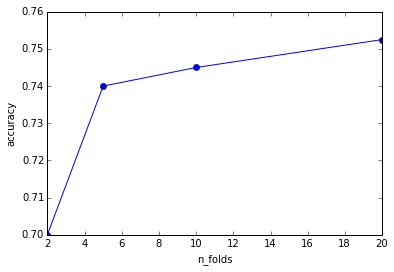

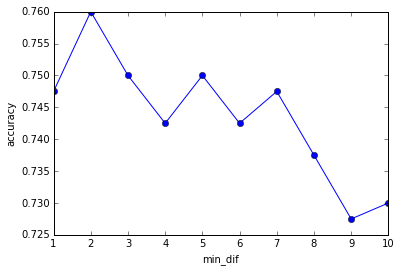

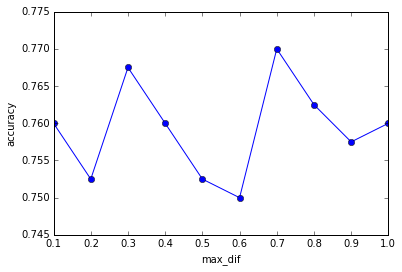

In [77]:
# Do not modify.
import json
outf = open('output.txt', 'wt')
clf.fit(X, y)

json.dump({
           'find_contexts': find_contexts(all_test_files[10], 'its', 10),
           'pred_term': most_predictive_term_in_doc(X_test[10], clf, 1),
           'top_errors': str(get_top_errors(X_test, y_test, all_test_files, clf)[0].items()),
           'get_files': get_files(path + os.sep + 'train' + os.sep + 'pos')[:10],
           'get_true_labels_pos': list(get_true_labels(get_files(path + os.sep + 'train' + os.sep + 'pos')[:5])),
           'get_true_labels_neg': list(get_true_labels(get_files(path + os.sep + 'train' + os.sep + 'neg')[:5])),
           'tokenize': tokenize('Hi-there-what_is UP????'),
           'tokenize_punct': tokenize_with_punct('Hi-there-what_is UP????'),
           'tokenize_not': tokenize_with_not('Hi-that is not cool . at all . not'),
           'vec': sorted(do_vectorize(get_files(path + os.sep + 'train' + os.sep + 'pos')[:10])[0][8].nonzero()[1].tolist())[:10],
           'vec_nonbinary': sorted(do_vectorize(get_files(path + os.sep + 'train' +
                                                         os.sep + 'pos')[:10], binary=False)[0][8].data)[::-1][:10],
           'cv10': '%.4f' % do_cross_validation(X[:100], y[:100], verbose=False, n_folds=10),
           'cv3': '%.4f' % do_cross_validation(X[:100], y[:100], verbose=False, n_folds=3),
           'nfolds_expt': ['%.4f' % v for v in compare_n_folds(filenames, y)],
           'binary_expt': ['%.4f' % v for v in compare_binary(filenames, y)],
           'tokenizer_expt': ['%.4f' % v for v in tokenizer_expt(filenames, y)],
           'mindf_expt': ['%.4f' % v for v in min_df_expt(filenames, y)],
           'maxdf_expt': ['%.4f' % v for v in max_df_expt(filenames, y)],
           'top_coef': get_top_coefficients(clf, vec, n=3),
           'rem_feat': '%.4f' % accuracy_score(train_after_removing_features(X.copy(), y, vec, ['worst']).predict(X_test), y_test),
          },
          outf, indent=2, sort_keys=True)
outf.close()